# **게임 리뷰를 통해 유저들의 민심 알아보기 (GTA5)**


원래 하고 싶었던 프로젝트는 게임을 하나 정하여 해당 게임에 대한 정보 혹은 평가 등을 공유 하는 커뮤니티들의 게시글들을 수집하고 해당 게시글들을 딥러닝을 통해서 유저들의 게임에 대한 평가/추천도/감정등을 분석하고 싶었습니다. 


하지만 데이터를 모으고 전처리하는 과정에 시간이 상당히 소요될 것 같아 Kaggle에 있는 GTA5에 대한 리뷰 데이터를 사용하여 유저들이 게임을 해보고 이 게임을 추천하는지 하지않는지를 알아보는 프로젝트로 변경하여 진행하게 되었습니다.

# 데이터 불러오기


데이터는 Kaggle의 steam Comments라는 데이터를 사용하였습니다.

https://www.kaggle.com/charliewu0729/steam-comments

In [1]:
from google.colab import drive  #구글 드라이브 연결

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
 
df = pd.read_csv('/content/drive/MyDrive/gtav_english.csv')  #데이터 불러오기

# 데이터 전처리


제가 사용한 데이터에는 코멘트를 입력한 유저의 이름,날짜,플레이타임,추천 여부,코멘트,해당 코멘트의 링크로 이루어져있었습니다.

제가 이번 프로젝트로 알고자 한건 코멘트의 내용을 통해 게임 추천 여부를 파악하는 것이였습니다.

따라서 불필요하다고 여겨지는 이름,날짜,플레이타임,링크에 대한 정보는 제거하였고, 추가적으로 추천 비추천도 0과 1로 바꿔 라벨링해주었습니다.



In [5]:
df = df.drop(['Name','Date','PlayTime','Link'],axis=1)  #불필요 컬럼 제거

In [6]:
change_value_dict = {'Not Recommended':0, 'Recommended':1}  #추천하지 않는다 0 , 추천한다 1
df = df.replace({'Recommend':change_value_dict})

추천 비추천의 비율은 비추천이 58.9% 추천이41.1%로 비추천의 비율이 높았습니다.

In [7]:
df['Recommend'].value_counts() #타겟 밸류

0    43227
1    30113
Name: Recommend, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9994a87f90>],
      dtype=object)

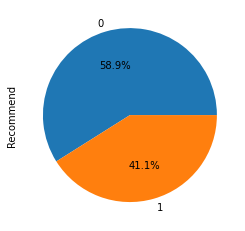

In [28]:
df['Recommend'].value_counts().plot(kind='pie',  subplots=True, autopct='%1.1f%%')

그리고 후에 코멘트들을 모두 소문자로 바꿔주고 특수문자들은 제거하는 작업을 해주었습니다.

In [8]:
df = df.astype({'Text':'string'})

In [9]:
df['Text'] = df['Text'].str.lower() #소문자로 모두 변경

In [10]:
import re

regex = r"[^a-zA-Z0-9 ]"

subst = ""

In [11]:
def tokenize(text):
    tokens = re.sub(regex, subst, str(text))
    return tokens

In [12]:
df['Text'] = df['Text'].apply(tokenize)   #특수문자 등 제거
df.head()

,Recommend,Text
0,0,after more than 1000 hours 3 shark cards inves...
1,0,firstly ive been with steam now for 13 years i...
2,0,best anti cheat system ever d ban legit player...
3,0,i login to gta online after not having played ...
4,0,gta v pre purchase 6999megalodon shark card 10...


불용어에 대해서는 기본적인 불용어들을 제거 해준 후 추가로 사용빈도는 높지만 분석에 필요가 없다고 생각되는 단어들을 제거하였고, 문장을 토큰화 하여 저장했습니다.

In [13]:
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")

tokenizer = Tokenizer(nlp.vocab)

In [14]:
tokens = []
# 토큰에서 불용어 제거, 소문자화 하여 업데이트
for doc in tokenizer.pipe(df['Text']):
    doc_tokens = []

    # A doc is a sequence of Token(<class 'spacy.tokens.doc.Doc'>)
    for token in doc:
        # 토큰이 불용어와 구두점이 아니면 저장
        if (token.is_stop == False) & (token.is_punct == False):
            doc_tokens.append(token.text.lower())

    tokens.append(doc_tokens)

df['tokens'] = tokens
df.tokens.head()

0    [1000, hours, 3, shark, cards, invested, mod, ...
1    [firstly, ive, steam, 13, years, far, games, c...
2    [best, anti, cheat, system, d, ban, legit, pla...
3    [login, gta, online, having, played, months, p...
4    [gta, v, pre, purchase, 6999megalodon, shark, ...
Name: tokens, dtype: object

In [15]:
from collections import Counter

word_counts = Counter()

df['tokens'].apply(lambda x: word_counts.update(x))

word_counts.most_common(10)

[('game', 73333),
 (' ', 30396),
 ('online', 24943),
 ('gta', 20027),
 ('money', 16650),
 ('rockstar', 16631),
 ('play', 14999),
 ('dont', 12763),
 ('fun', 12530),
 ('good', 12247)]

In [16]:
STOP_WORDS = nlp.Defaults.stop_words.union(['game',' ','online','gta','money','rockstar','play','dont'])

In [17]:
tokens = []

for doc in tokenizer.pipe(df['Text']):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [18]:
df.tokens.head()

0    [1000, hours, 3, shark, cards, invested, mod, ...
1    [firstly, ive, steam, 13, years, far, games, c...
2    [best, anti, cheat, system, d, ban, legit, pla...
3    [login, having, played, months, completely, fi...
4    [v, pre, purchase, 6999megalodon, shark, card,...
Name: tokens, dtype: object

그리고 사용되는 단어가 굉장히 많을 것 같아 빈도가 높은 단어들만 추려서 학습을 하고자 아래와 같이 빈도가 높은 단어들을 뽑아내 갯수를 확인했습니다.

In [19]:
def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [20]:
wc = word_count(df['tokens'])

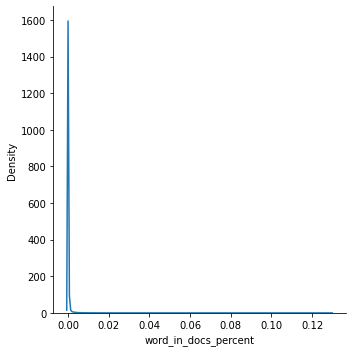

In [29]:
import seaborn as sns

sns.displot(wc['word_in_docs_percent'],kind='kde')

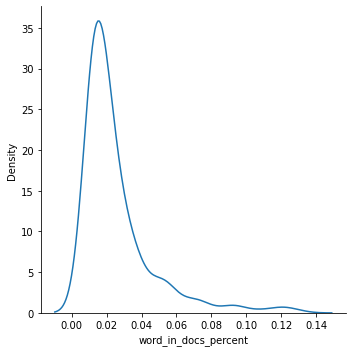

In [30]:
wc = wc[wc['word_in_docs_percent'] >= 0.01]

sns.displot(wc['word_in_docs_percent'], kind='kde');

In [31]:
wc  #323개

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
77,fun,9015,12530,1.0,0.008021,0.008021,0.122921
157,good,9479,12247,2.0,0.007840,0.015860,0.129247
185,like,8176,12209,3.0,0.007815,0.023675,0.111481
262,mods,8777,11986,4.0,0.007672,0.031348,0.119675
310,buy,8791,11912,5.0,0.007625,0.038973,0.119866
...,...,...,...,...,...,...,...
1850,recent,752,823,333.0,0.000527,0.491013,0.010254
2528,refund,734,822,334.0,0.000526,0.491539,0.010008
166,leave,735,799,339.0,0.000511,0.494130,0.010022
74,wasnt,740,794,340.0,0.000508,0.494638,0.010090


# LSTM모델

먼저 데이터를 학습하기전 학습/검증 세트로 나누어 주었고 토큰화 과정에서 앞서 알아본 빈도 높은 323개의 단어만 사용하기위해 323으로 지정해주고 진행하였습니다.

In [32]:
from sklearn.model_selection import train_test_split

X = df['tokens']
y = df['Recommend']

X_train, X_test = train_test_split(X, test_size = 0.2, random_state=42)
y_train, y_test = train_test_split(y, test_size = 0.2, random_state=42)

In [65]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

max_words = 323
max_len = 400

tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)

sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences2 = tok.texts_to_sequences(X_test)
sequences_matrix2 = sequence.pad_sequences(sequences2, maxlen=max_len)

In [97]:
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding

def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,64,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    return model

In [67]:
model = RNN()
model.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 400)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 400, 64)           20672     
_________________________________________________________________
lstm_5 (LSTM)                (None, 64)                33024     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_10 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [68]:
history = model.fit(sequences_matrix,y_train,batch_size=128,epochs=20, validation_data=(sequences_matrix2,y_test))

Epoch 1/20
459/459 [==============================] - 14s 27ms/step - loss: 0.4239 - accuracy: 0.7934 - val_loss: 0.3863 - val_accuracy: 0.8143
Epoch 2/20
459/459 [==============================] - 12s 26ms/step - loss: 0.3809 - accuracy: 0.8191 - val_loss: 0.3755 - val_accuracy: 0.8184
Epoch 3/20
459/459 [==============================] - 12s 26ms/step - loss: 0.3692 - accuracy: 0.8237 - val_loss: 0.3700 - val_accuracy: 0.8214
Epoch 4/20
459/459 [==============================] - 12s 26ms/step - loss: 0.3634 - accuracy: 0.8267 - val_loss: 0.3708 - val_accuracy: 0.8186
Epoch 5/20
459/459 [==============================] - 12s 25ms/step - loss: 0.3589 - accuracy: 0.8295 - val_loss: 0.3679 - val_accuracy: 0.8209
Epoch 6/20
459/459 [==============================] - 12s 26ms/step - loss: 0.3552 - accuracy: 0.8297 - val_loss: 0.3647 - val_accuracy: 0.8229
Epoch 7/20
459/459 [==============================] - 12s 25ms/step - loss: 0.3523 - accuracy: 0.8305 - val_loss: 0.3683 - val_accuracy:

모델의 결과를 그래프로 확인해 보았습니다.

epoch의 수가 늘어나며 학습데이터에 loss값은 줄어들고 있으나 검증데이터에 대한 loss값은 비슷한 값을 유지하고 있으며

정확도의 경우 학습/검증 데이터 모두 상승하고 있는 것을 알 수 있었습니다.

loss도 줄이며 정확도도 오를 수 있게 개선할 수 있는 여지가 있다고 생각됩니다.

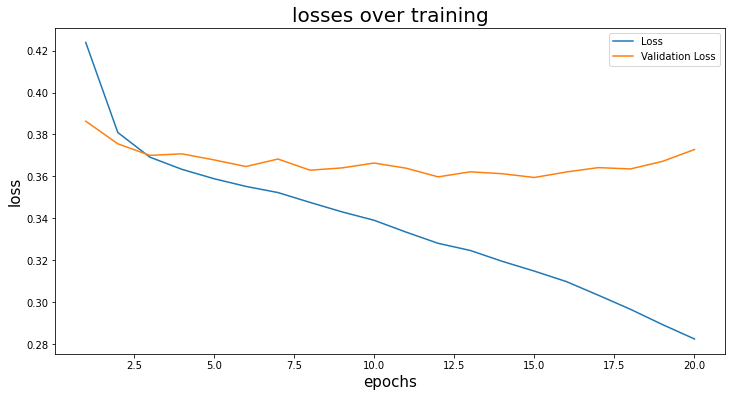

In [69]:
import numpy as np

plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['loss'], label='Loss')
plt.plot(np.arange(20)+1, history.history['val_loss'], label='Validation Loss')
plt.title('losses over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('loss', fontsize=15)

plt.legend()
plt.show()

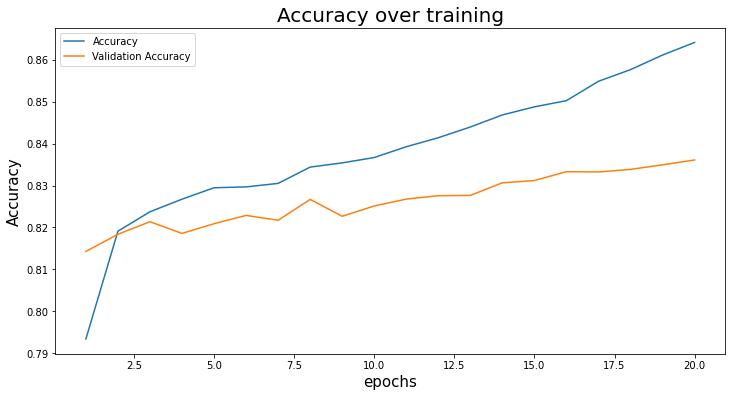

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(20)+1, history.history['accuracy'], label='Accuracy')
plt.plot(np.arange(20)+1, history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over training', fontsize=20)

plt.xlabel('epochs', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)

plt.legend()
plt.show()

k-fold cross validation을 진행해보았습니다.

5-fold로 진행 하였고 0.84로 위의 모델과 큰 차이가 나지 않는 것으로 보아 일반화가 어느 정도 괜찮게 된 것 같습니다.

In [75]:
from sklearn.model_selection import KFold, cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier

In [98]:
model = KerasClassifier(build_fn=RNN, epochs=20, batch_size=10, verbose=0)

In [99]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42) 
results = cross_val_score(model, sequences_matrix, y_train, cv=kfold)

In [100]:
results

array([0.84559011, 0.83553475, 0.84838927, 0.84165674, 0.84174192])

In [102]:
results.mean()

0.8425825595855713

In [103]:
!pip freeze > requirements.txt